<a href="https://colab.research.google.com/github/aman5319/Meetup2019/blob/master/Session_2/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# torch installation
!pip install torch torchvision
!pip install Pillow==4.0.0

#generic
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from pathlib import Path
from tqdm import tqdm


#torch Dependencies
import torch
from torchvision import datasets , transforms
from torch.utils.data import Dataset , DataLoader
import torchvision


#keras Dependencies
import keras
from keras.preprocessing.image import ImageDataGenerator

#setting cuda for gpu in torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


# Data Augmentation

## what is Data Augmentation ?
----> Data Augmentation is a technique to add variance in data so that the model generalizes better.
            
----> We Perform data augmentation more specifically image augmentation in cnn through simple techniques, such as cropping, rotating and flipping  input  images horizontally or vertically.

-----> For example in Cats verses Dogs, if a model is trained only on perfect complete cats and dogs then while prediction if the model gets a half cropped image it won't be able to predict correct result.

----->  Augmentation is also a form of adding prior knowledge to a model; e.g. images are rotated, which you know does not change the class label. Increasing training data (as with augmentation) decreases a model's variance. Regularization also decreases a model's variance. They do so in different ways, but ultimately both decrease regularization error.

-----> Pytorch and Keras support a basic set of image augmentation techniques and we are going to see it on Cifar-10 dataset.

-----> [ImgAug](https://imgaug.readthedocs.io/en/latest/) is library specific for augmentation purpose. It  supports a wide range of augmentation techniques, allows to easily combine these and to execute them in random order or on multiple CPU cores, has a simple yet powerful stochastic interface and can not only augment images, but also keypoints/landmarks, bounding boxes, heatmaps and segmentation maps.


## Data Augmentation in Pytorch and visualization

In [0]:
#Transforms are common image transformations. They can be chained together using Compose.
# pytorch gives many transformation on PIL image so if you get a tensor by default first convert it to PIL image then apply transformation 
# and then convert back to tensor or else it can be used directly
transform = transforms.Compose([transforms.RandomRotation((0,5),resample = PIL.Image.NEAREST), 
                                 transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.CenterCrop(size=26),
                                transforms.ToTensor()])

In [161]:

trainSet = datasets.CIFAR10(root="./data/pytorch" , train=True,download=True,transform=transform) #This returns the dataset 

trainLoader = DataLoader(trainSet , batch_size=16,shuffle=True) # Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

classes = ('plane', 'car', 'bird', 'cat' , 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')# cifar 10 classes

Files already downloaded and verified


In [0]:
def denormalize(image):
  #because pytorch takes data in C * H * W  order we need to convert to H * W* C for visualizing in pytorch
  image = image.permute(1,2,0) # it transposes the dimensions
  return image
  

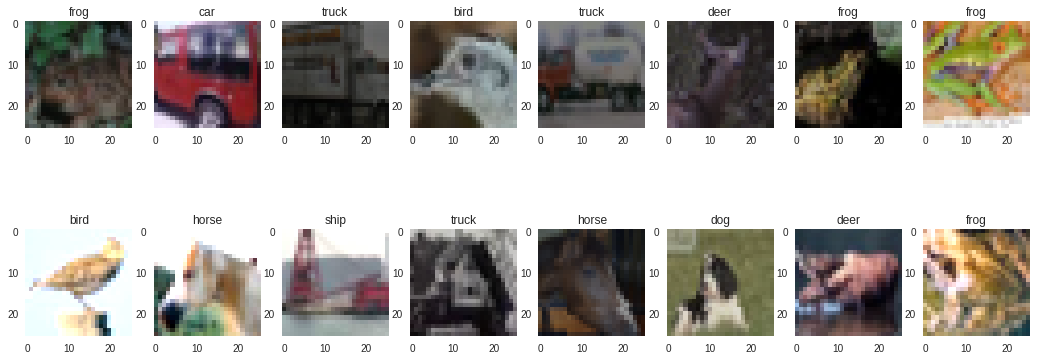

In [163]:
#As we can see we have given batch size of 16 so
# visualizing the image

data = next(iter(trainLoader))
images , labels = data
nrows=2
ncols = len(data[0])//nrows 
plt.figure(figsize=(18,7))
for i in range(len(images)):
  plt.subplot(nrows,ncols,i+1)
  plt.grid(False)
  plt.imshow(denormalize(images[i]))
  plt.title(classes[labels[i]])
plt.show()
  

## Normalization

In [200]:
#Other important technique is normalization of image we do a channel wise normalization by subtracting the channel wise mean by standard deviation 
# we perform this to keep all the input images in similar range and thus getting a stable gradient
train_data = datasets.CIFAR10('./data/pytorch', train=True)
# use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))], axis=0)
# print(x)
print(x.shape)
# calculate the mean and std along the (0, 1) axe
mean = np.mean(x,axis=(0,1))
std=np.std(x,axis=(0,1))
print(mean , std)
mean , std = torch.from_numpy(mean) , torch.from_numpy(std)


(1600000, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]


Files already downloaded and verified


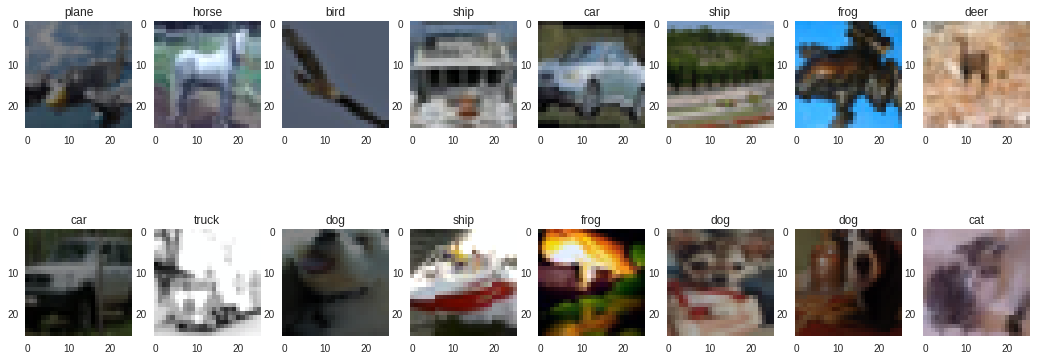

In [203]:
transform = transforms.Compose([transforms.RandomRotation((0,5),resample = PIL.Image.NEAREST), 
                                 transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.CenterCrop(size=26),
                                transforms.ToTensor(),
                               transforms.Normalize(mean ,std)]) ## normalize

trainSet = datasets.CIFAR10(root="./data/pytorch" , train=True,download=True,transform=transform)  

trainLoader = DataLoader(trainSet , batch_size=16,shuffle=True)

classes = ('plane', 'car', 'bird', 'cat' , 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')# cifar 10 classes

def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image

data = next(iter(trainLoader))
images , labels = data
nrows=2
ncols = len(data[0])//nrows 
plt.figure(figsize=(18,7))
for i in range(len(images)):
  plt.subplot(nrows,ncols,i+1)
  plt.grid(False)
  plt.imshow(denormalize(images[i]))
  plt.title(classes[labels[i]])
plt.show()


# References
1.  https://pytorch.org/docs/stable/torchvision/index.html

2. http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf

3. https://pytorch.org/docs/stable/tensors.html

4. https://keras.io/preprocessing/image/ (For Keras Implementation of same thing)